In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph, NearestCentroid
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

In [10]:
words = []
word_vectors = []

In [11]:
with open('hw3/nmt-en-dec-512.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
    for line in lines:
        splitted = line.split()
        word = splitted[0]
        vector = [float(el) for el in splitted[1:]]
        vector = np.array(vector)
        
        words.append(word)
        word_vectors.append(vector)

In [12]:
word_vectors = np.array(word_vectors)

In [13]:
words = np.array(words)

In [14]:
word_vectors.shape

(5000, 512)

# Task 1

Visualize the word vectors in 2D using the T-SNE method. Use the `sklearn.manifold.TSNE` function. Learn how T-SNE works and what parameters it has. Draw a scatterplot with a reasonable amount of labels, so that it is readable and you can identify different clusters of words. 

In [15]:
X_TSNE = TSNE(n_components=2, 
              learning_rate='auto',
              verbose=1,
              init='random').fit_transform(word_vectors)
print(X_TSNE.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.532s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.820730
[t-SNE] KL divergence after 250 iterations with early exaggeration: 103.945816
[t-SNE] KL divergence after 1000 iterations: 2.534392
(5000, 2)


In [16]:
def plot_word_embeddings(embeddings, 
                         color="#C1E3B8", 
                         fontsize=12,
                         annotation_freq=50, 
                         seed=1234, 
                         first_dim=0, 
                         second_dim=1):
    plt.figure(figsize=(15, 12))
    plt.scatter(embeddings[:, first_dim], embeddings[:, second_dim], c=color)
    
    np.random.seed(seed)
    indices = np.random.choice(embeddings.shape[0], annotation_freq, replace=False)  
    
    for i in indices:
        y = embeddings[i]
        word_label = words[i]
        plt.annotate(word_label, (y[first_dim], y[second_dim]), fontsize=fontsize)

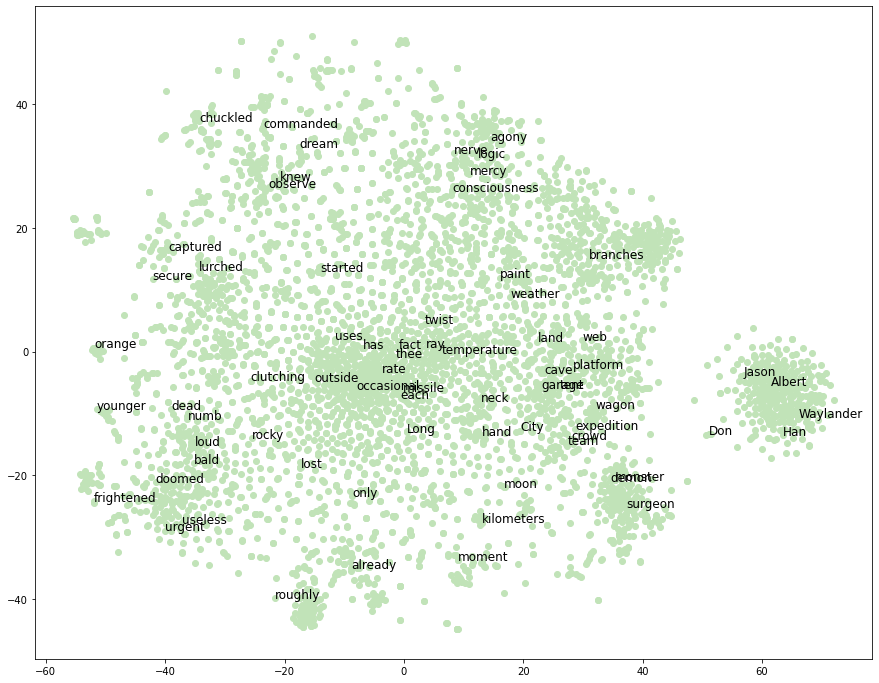

In [17]:
plot_word_embeddings(X_TSNE, annotation_freq=70)

# Task 2

Cluster the word vectors in the original 512-dimensional vector space using the methods of K-means, GaussianMixture, and Aglomerative clustering. Use the functions implemented in the `sklearn` library. Try different
number of clusters (3,5,10) and different linkage strategies (ward, single, complete). Visualize the clusters using different colors in T-SNE. Compute the Silhouette coeficients of the individual clusterings. Use `sklearn.metrics.silhouette_score`. What method is the best? What
methods failed? 

In [18]:
# This method creates the clusterer object based on the parameter "method", and 
# does the clustering into "n_clusters" number of clusters. Linkage strategy is
# optional and it is used only for Agglomerative Clustering.
def cluster(X, method, n_clusters, linkage_strategy=None):
    n_neighbors = 10
    
    clusterer = None
    if method == "K-means":
        clusterer = KMeans(
            n_clusters=n_clusters, 
            init='random',
            n_init=10, 
            max_iter=300, 
            tol=1e-04, 
            random_state=1
        )
    
    elif method == "Gaussian Mixture":
        clusterer = GaussianMixture(n_components=n_clusters, covariance_type="full")
        
    elif method == "Agglomerative Clustering":
        # connectivity matrix for structured Ward
        connectivity = kneighbors_graph(
            X, n_neighbors=n_neighbors, include_self=False
        )
        
        clusterer = AgglomerativeClustering(
            linkage=linkage_strategy,
            n_clusters=n_clusters,
            connectivity=connectivity,
        )
    else:
        print("ERROR")
    
    return clusterer, clusterer.fit_predict(X)

In [19]:
# This method plots silhouette values for all 
# datapoints in the dataset X. Furthermore, it plots 
# the dataset X in 2D while coloring clusters 
# in different colors based on the cluster labels from Y
def plot_clusters(X, Y, n_clusters, method, sample_silhouette_values):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    silhouette_avg_str = "{:.5f}".format(silhouette_avg)
    ax1.set_title("The silhouette plot for the various clusters. Avg. sillhouette score: " + silhouette_avg_str)
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    if method == "Agglomerative Clustering":
        subtitle = "Silhouette analysis for {} clustering using {} linkage strategy with n_clusters = {}".format(method, linkage_strategy, n_clusters)
    else:
        subtitle = "Silhouette analysis for {} clustering with n_clusters = {}".format(method, n_clusters)
    plt.suptitle(subtitle, fontsize=14, fontweight="bold")

For n_clusters =  3 the average silhouette_score is: 0.033828204158780115
For n_clusters =  5 the average silhouette_score is: 0.03459523947851218
For n_clusters = 10 the average silhouette_score is: 0.02732128801749716
For n_clusters =  3 the average silhouette_score is: 0.03380787355025598
For n_clusters =  5 the average silhouette_score is: 0.029000018533540697
For n_clusters = 10 the average silhouette_score is: 0.028977982915093424
For n_clusters =  3 (linkage strategy: ward) the average silhouette_score is: 0.02506865796935428
For n_clusters =  5 (linkage strategy: ward) the average silhouette_score is: 0.023781375782857883
For n_clusters = 10 (linkage strategy: ward) the average silhouette_score is: 0.00967672203769523
For n_clusters =  3 (linkage strategy: single) the average silhouette_score is: 0.3999057045328436
For n_clusters =  5 (linkage strategy: single) the average silhouette_score is: 0.3380703302647055
For n_clusters = 10 (linkage strategy: single) the average silhoue

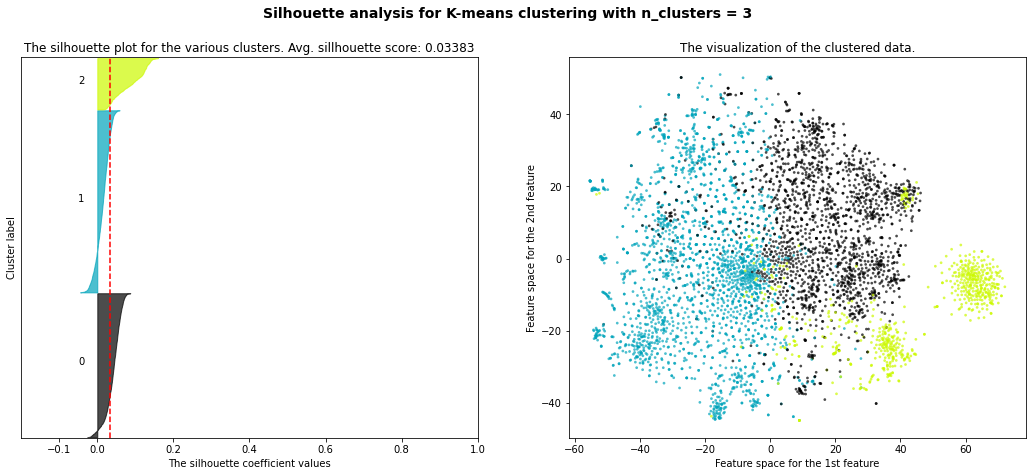

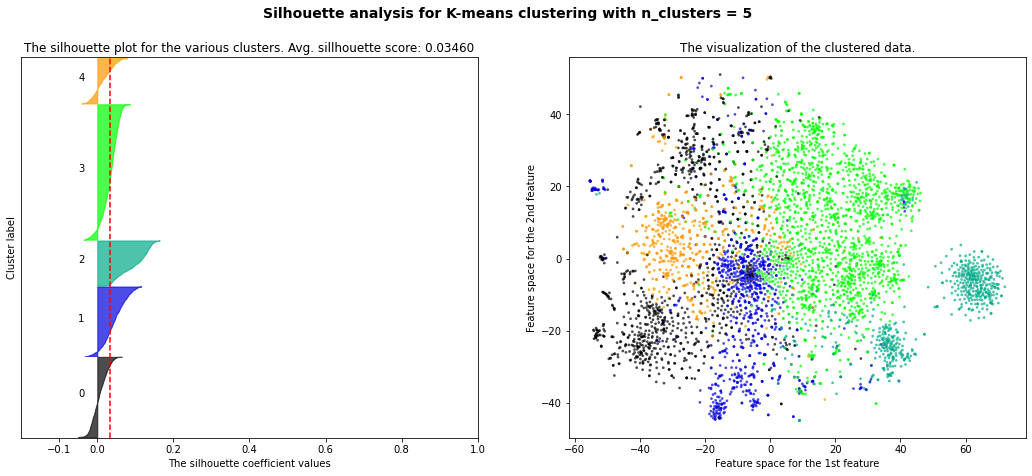

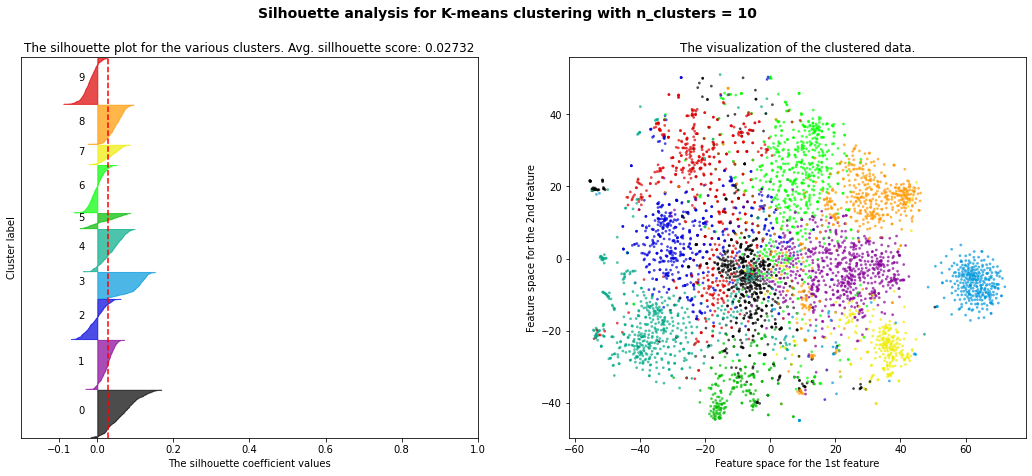

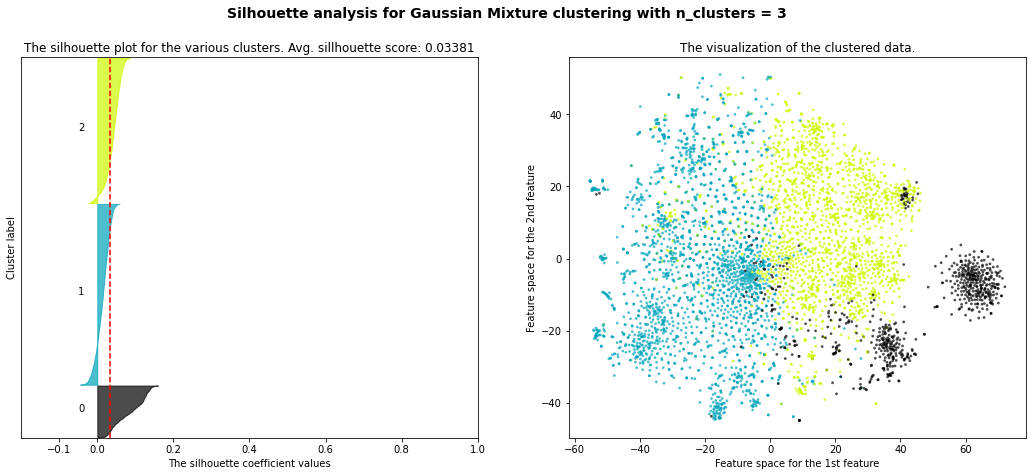

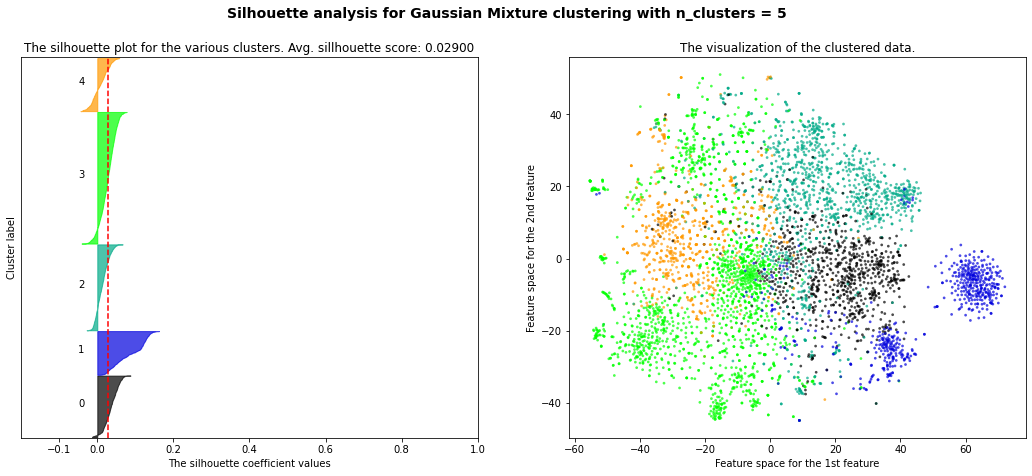

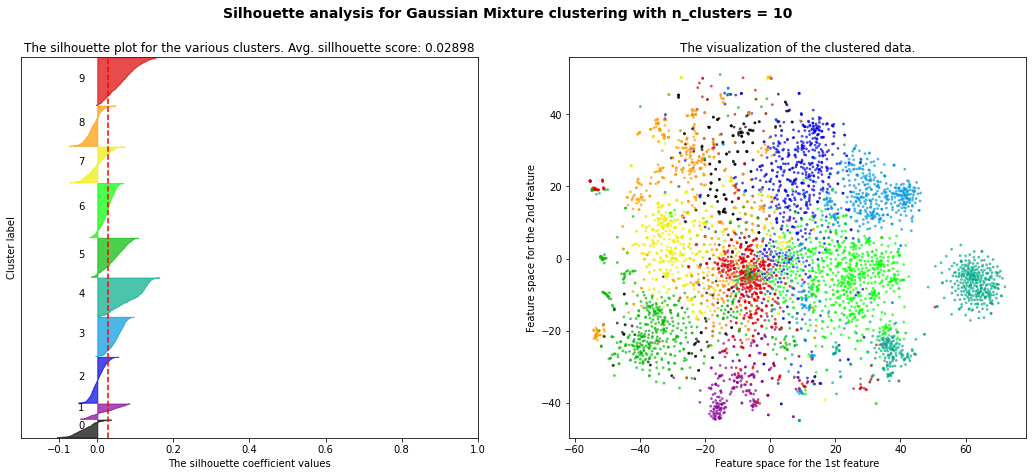

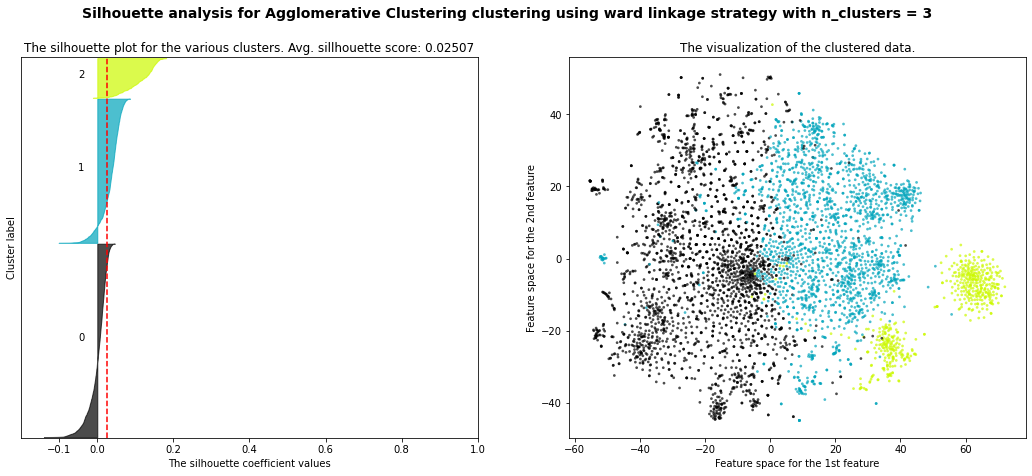

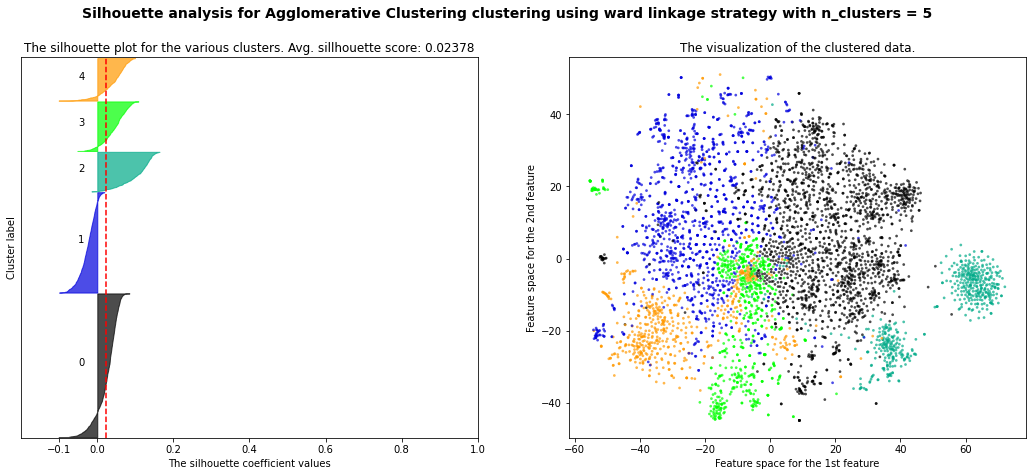

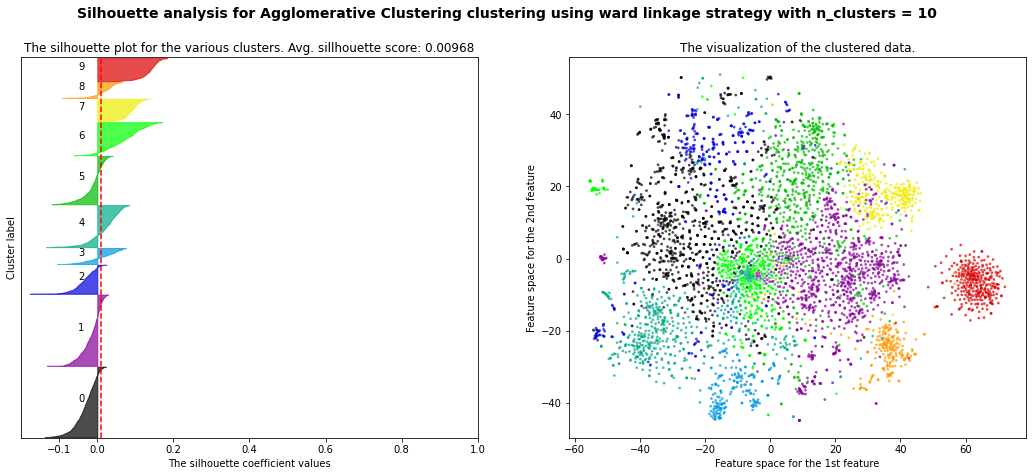

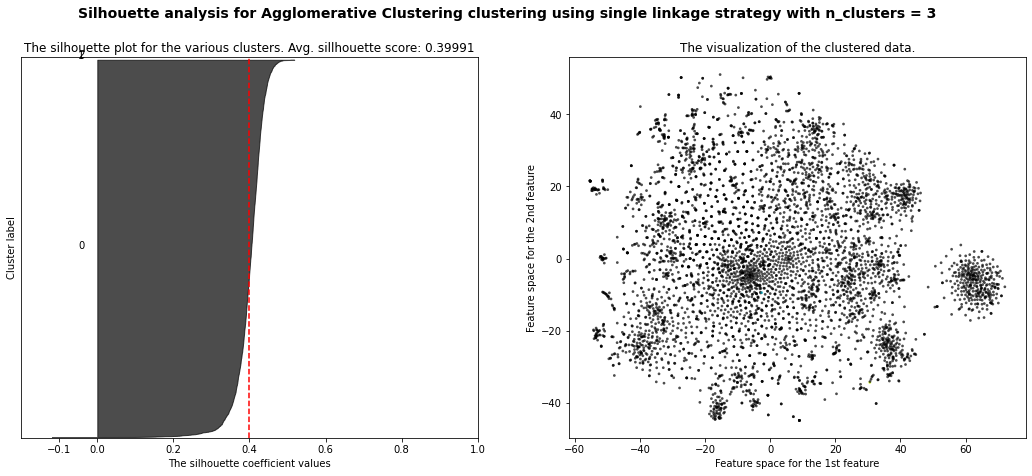

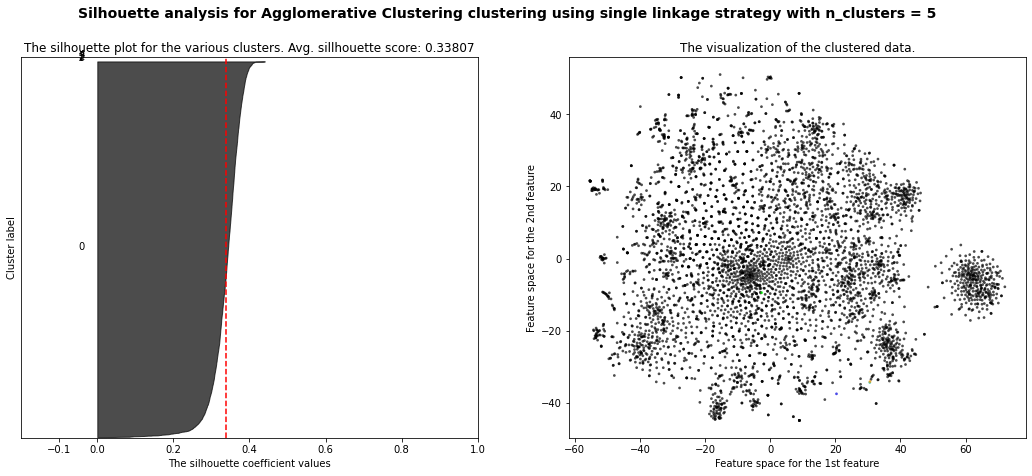

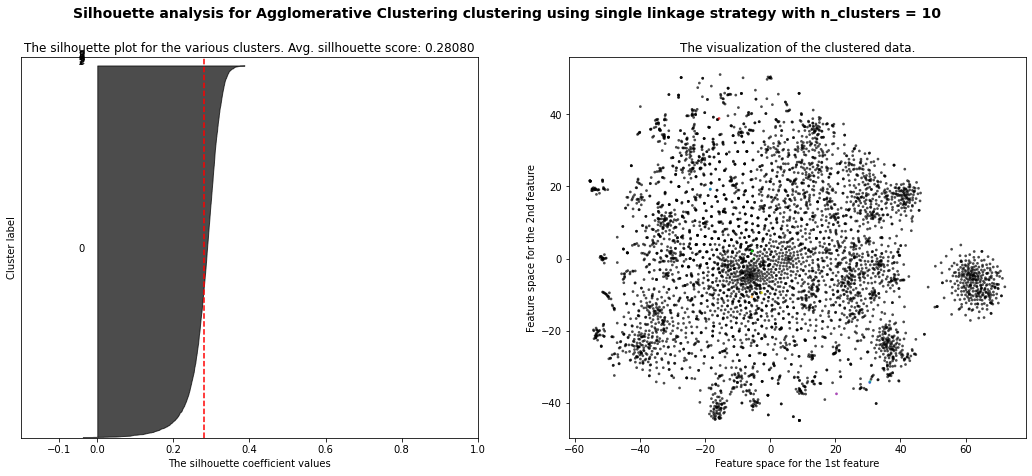

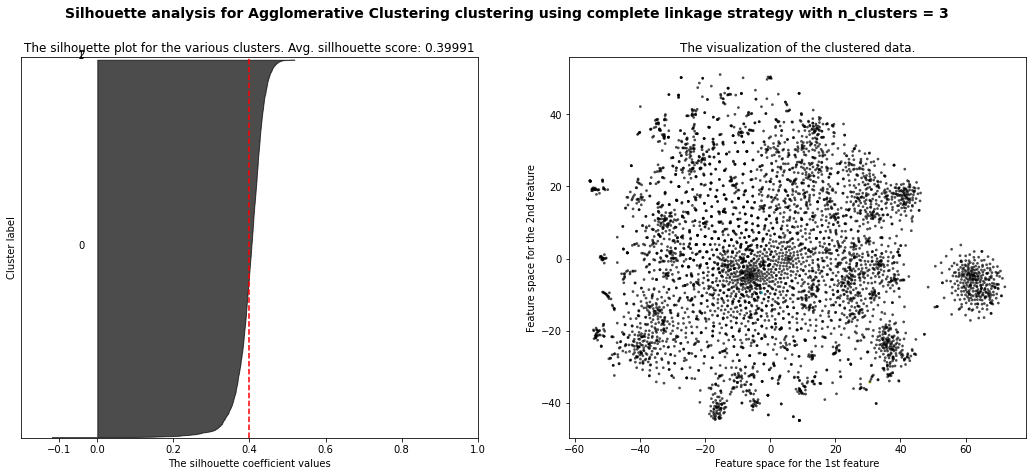

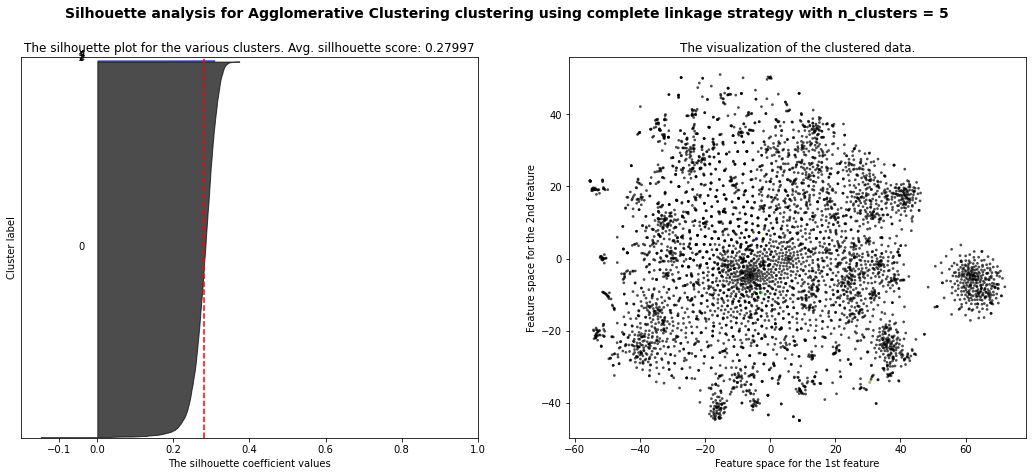

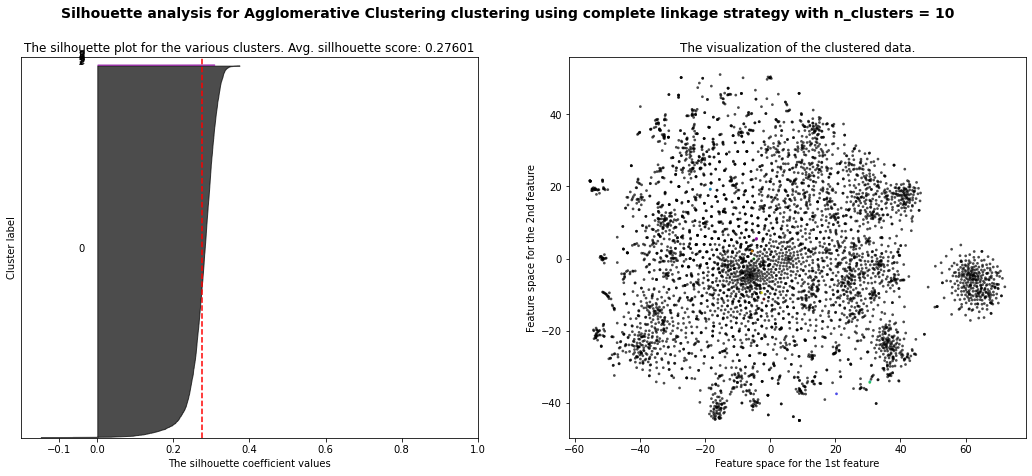

In [20]:
range_n_clusters = [3, 5, 10]
methods = ['K-means', 'Gaussian Mixture', 'Agglomerative Clustering']
linkage_strategies = ["ward", "single", "complete"]

results = []

for method in methods:
    for linkage_strategy in linkage_strategies:
        for n_clusters in range_n_clusters:
            # Initialize the clusterer with n_clusters value and a random generator
            # seed of 10 for reproducibility.
            clusterer, cluster_labels = cluster(word_vectors, method, n_clusters, linkage_strategy)

            silhouette_avg = silhouette_score(word_vectors, cluster_labels)
            if method == "Agglomerative Clustering":
                print("For n_clusters = {0:2} (linkage strategy: {1}) the average silhouette_score is: {2}".format(n_clusters, linkage_strategy, silhouette_avg))
            else:
                print("For n_clusters = {0:2} the average silhouette_score is: {1}".format(n_clusters, silhouette_avg))
            
            # Compute the silhouette scores for each sample
            sample_silhouette_values = silhouette_samples(word_vectors, cluster_labels)

            plot_clusters(X_TSNE, cluster_labels, n_clusters, method, sample_silhouette_values)

            linkage = linkage_strategy
            if method != "Agglomerative Clustering":
                linkage = ""
            results.append({
                "method" : method,
                "n_clusters": n_clusters,
                "linkage_strategy": linkage,
                "silhouette_score": silhouette_avg
            })
        if method != "Agglomerative Clustering":
            break
plt.show()

In [33]:
df_task2 = pd.DataFrame.from_records(results)

In [34]:
df_task2

method  n_clusters linkage_strategy  silhouette_score
0                    K-means           3                           0.033828
1                    K-means           5                           0.034595
2                    K-means          10                           0.027321
3           Gaussian Mixture           3                           0.033808
4           Gaussian Mixture           5                           0.029000
5           Gaussian Mixture          10                           0.028978
6   Agglomerative Clustering           3             ward          0.025069
7   Agglomerative Clustering           5             ward          0.023781
8   Agglomerative Clustering          10             ward          0.009677
9   Agglomerative Clustering           3           single          0.399906
10  Agglomerative Clustering           5           single          0.338070
11  Agglomerative Clustering          10           single          0.280803
12  Agglomerative Clustering           3         complete          0.399906
13  Agglomerative Clustering           5         complete          0.279969
14  Agglomerative Clustering          10         complete          0.276007

The methods that failed are Agglomerative Clustering with complete and single linkage strategy.

The best method is K-means with 5 clusters, with K-means with 3 clusters and Gaussian Mixture with 3 clusters not too far behind.

# Task 3

Perform the Principal Component Analysis on the data (use the function `sklearn.decomposition.PCA`). Visualise the data transformed into the first two principal components. Try to guess what features of words are represented by the first two components. Run the K-Means, Gaussian-Mixture, and Aglomerative clustering on the data transformed into the first two PCA componens. Compute the Silhouette coeficients and find the best number of clusters. Why the silhouette coeficients are so different from those in Task 2?

In [23]:
pca = PCA(n_components=20)
X_PCA_transformed = pca.fit_transform(word_vectors)

In [24]:
pca.explained_variance_

array([0.41020274, 0.33133671, 0.26009154, 0.22277086, 0.15887066,
       0.15033539, 0.14385383, 0.13296818, 0.12361491, 0.10875906,
       0.10403513, 0.09550348, 0.09194517, 0.08732662, 0.08291376,
       0.08009719, 0.07658217, 0.07530214, 0.06902422, 0.0686083 ])

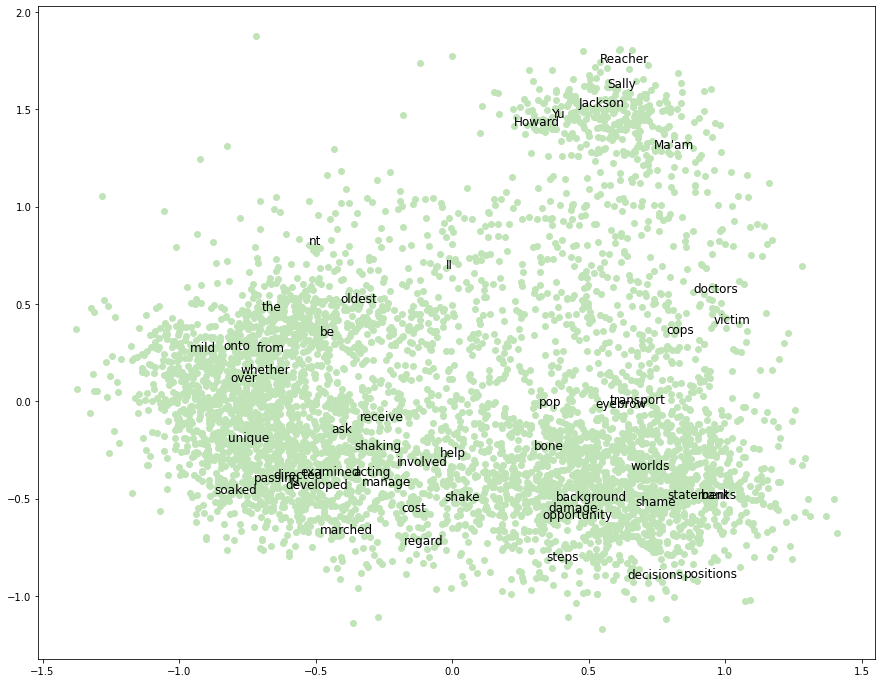

In [25]:
plot_word_embeddings(X_PCA_transformed, seed=151)

For n_clusters =  3 the average silhouette_score is: 0.5323482059818647
For n_clusters =  5 the average silhouette_score is: 0.2755104999560653
For n_clusters = 10 the average silhouette_score is: 0.02086580643160919
For n_clusters =  3 the average silhouette_score is: 0.20585140717489703
For n_clusters =  5 the average silhouette_score is: 0.2357750414308007
For n_clusters = 10 the average silhouette_score is: 0.0360027684198805
For n_clusters =  3 (linkage strategy: ward) the average silhouette_score is: 0.46115281215425047
For n_clusters =  5 (linkage strategy: ward) the average silhouette_score is: 0.22270994835424485
For n_clusters = 10 (linkage strategy: ward) the average silhouette_score is: -0.005938680394727329
For n_clusters =  3 (linkage strategy: single) the average silhouette_score is: 0.22639794660654192
For n_clusters =  5 (linkage strategy: single) the average silhouette_score is: -0.3331699831237731
For n_clusters = 10 (linkage strategy: single) the average silhouette_

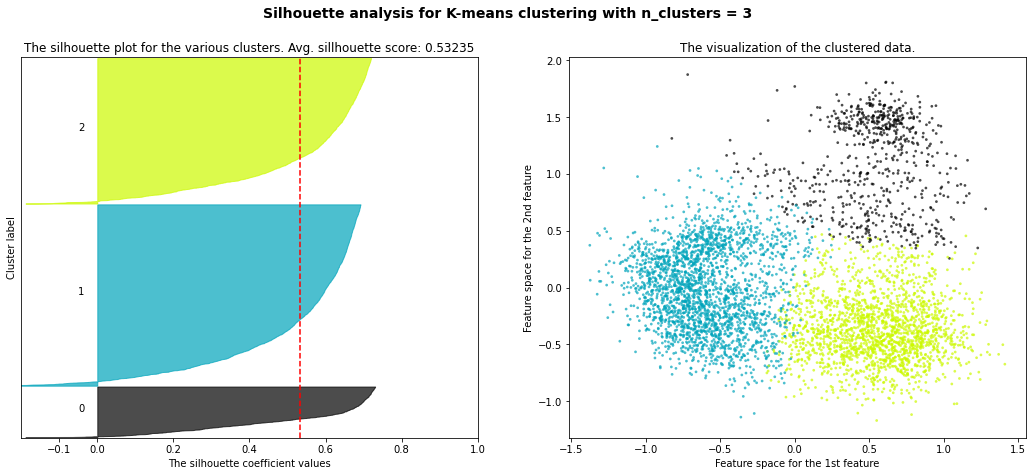

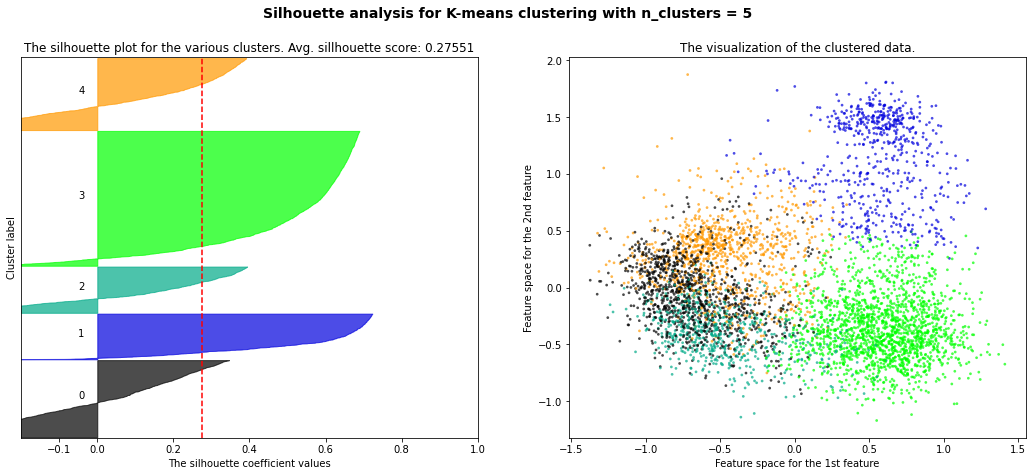

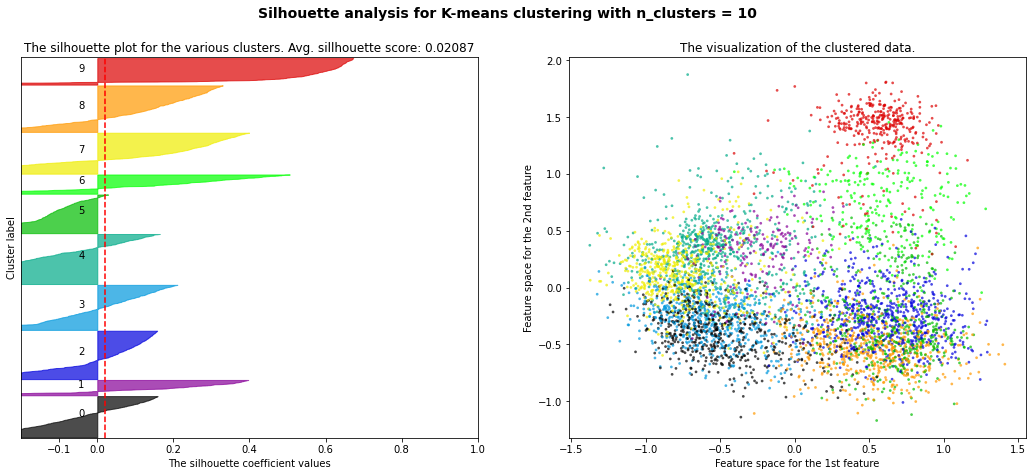

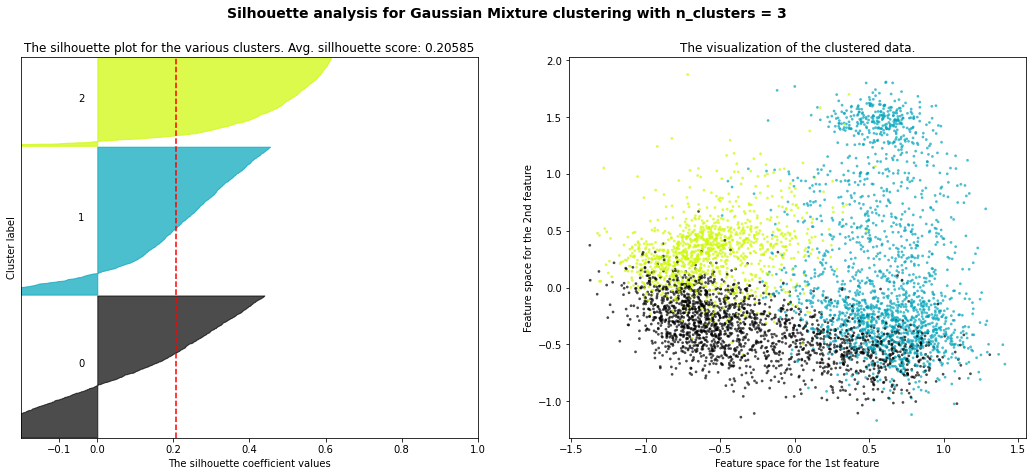

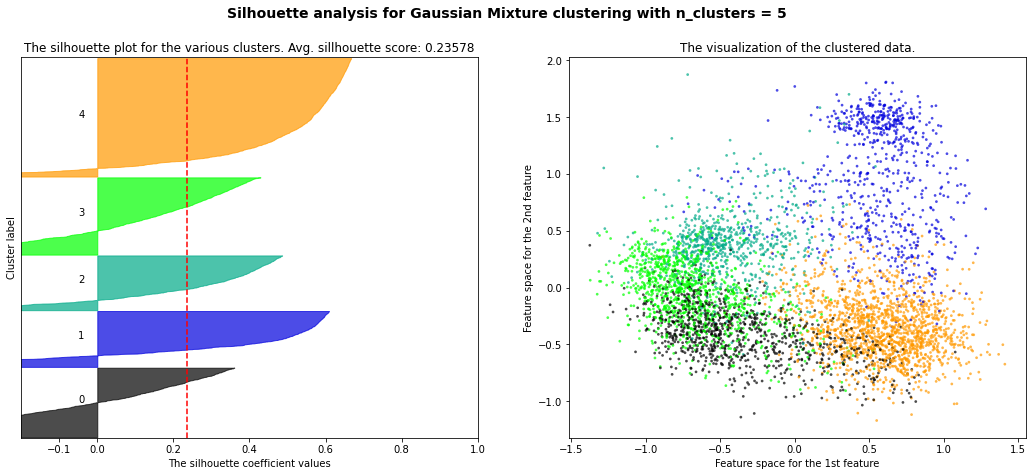

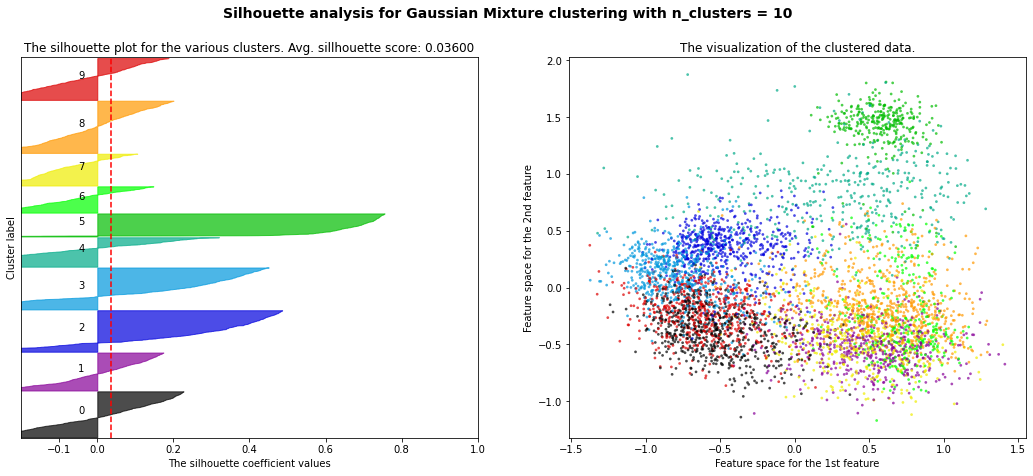

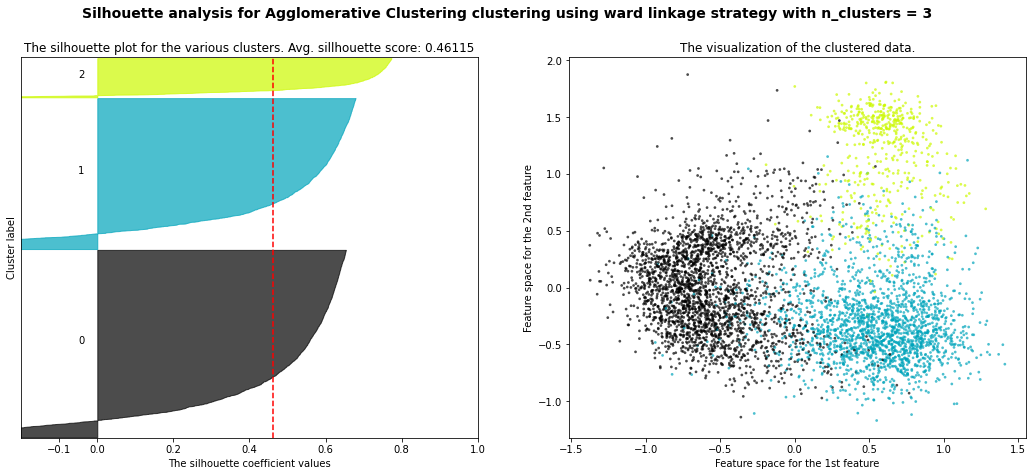

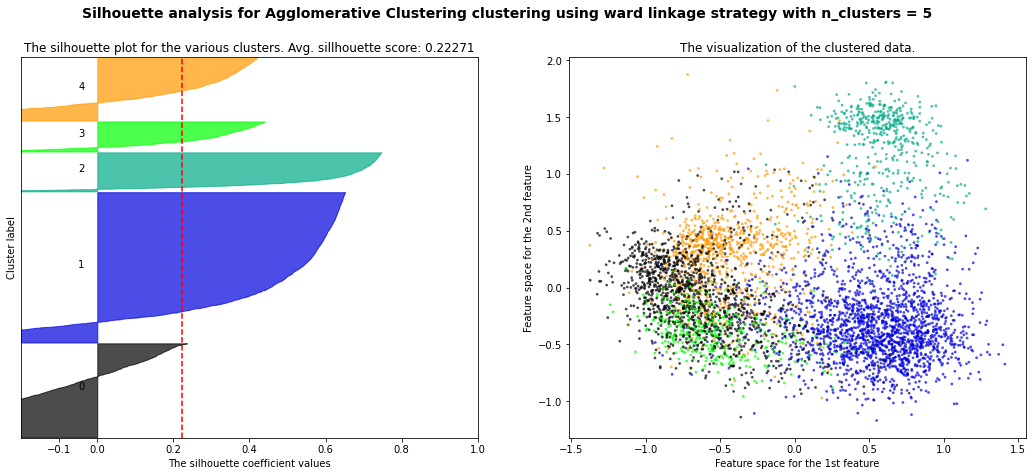

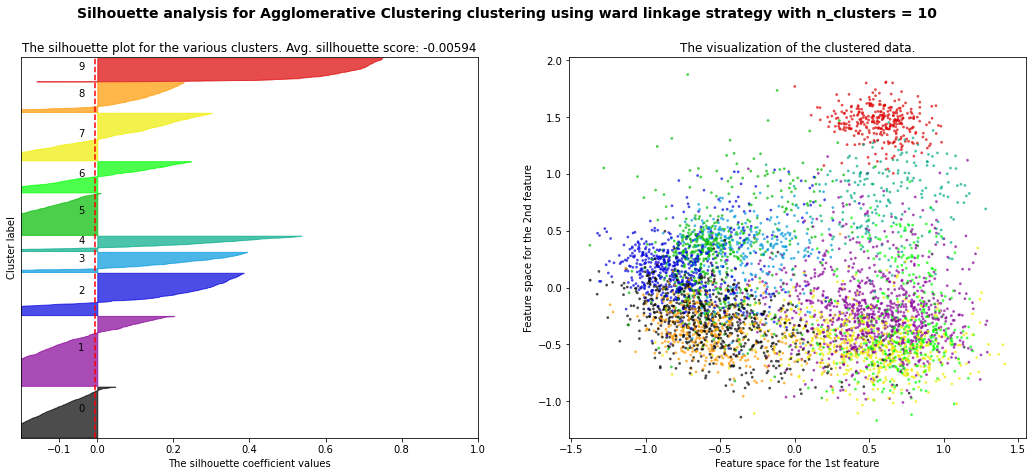

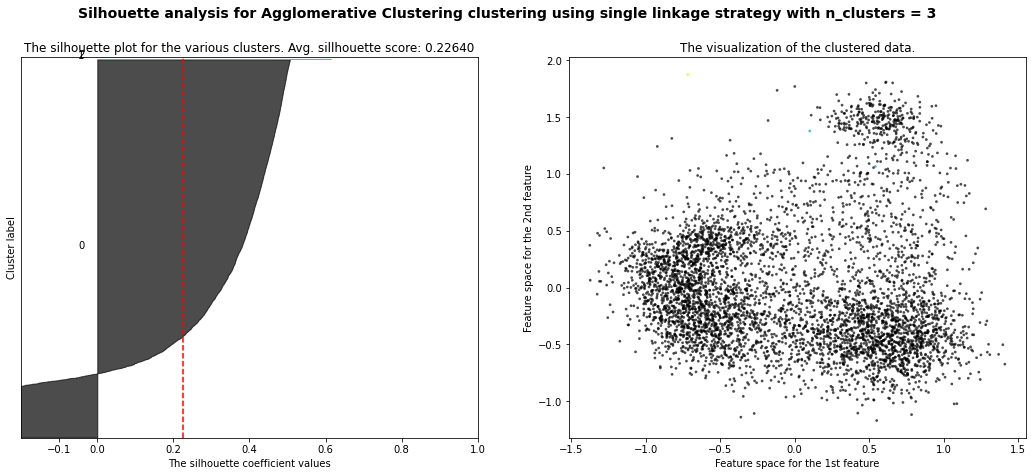

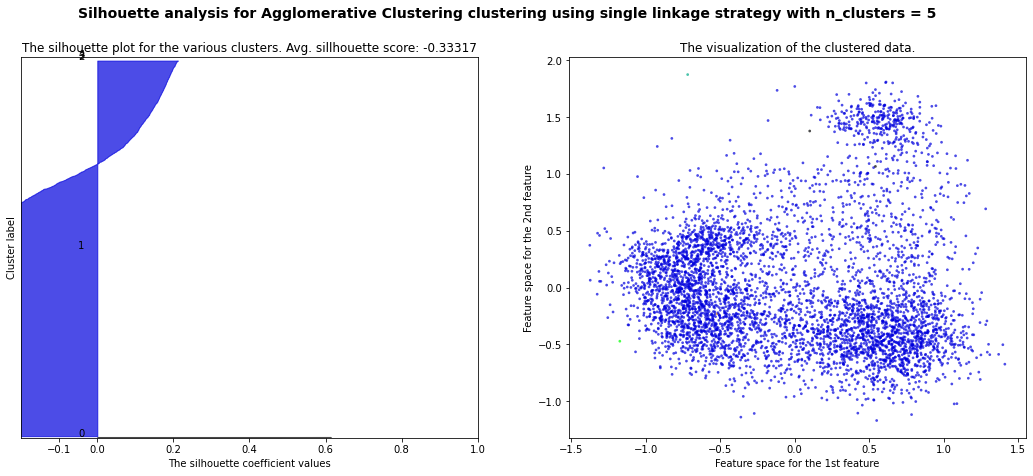

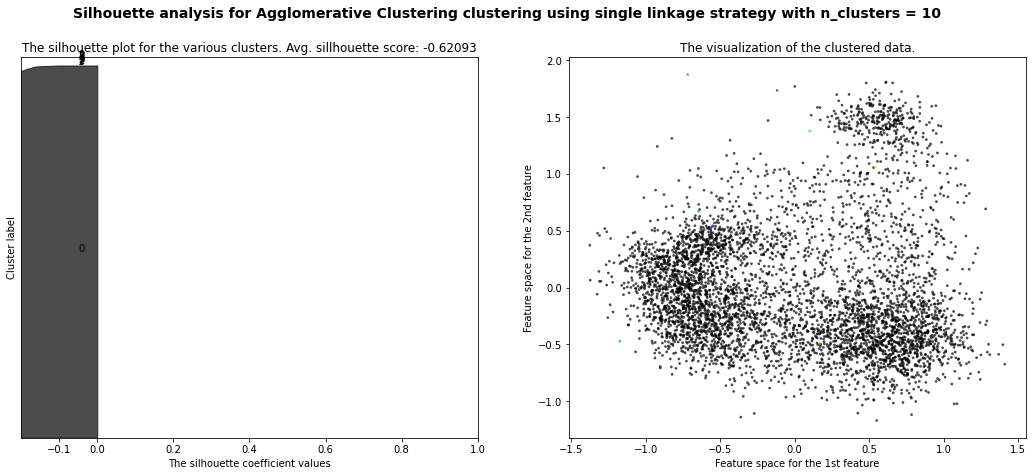

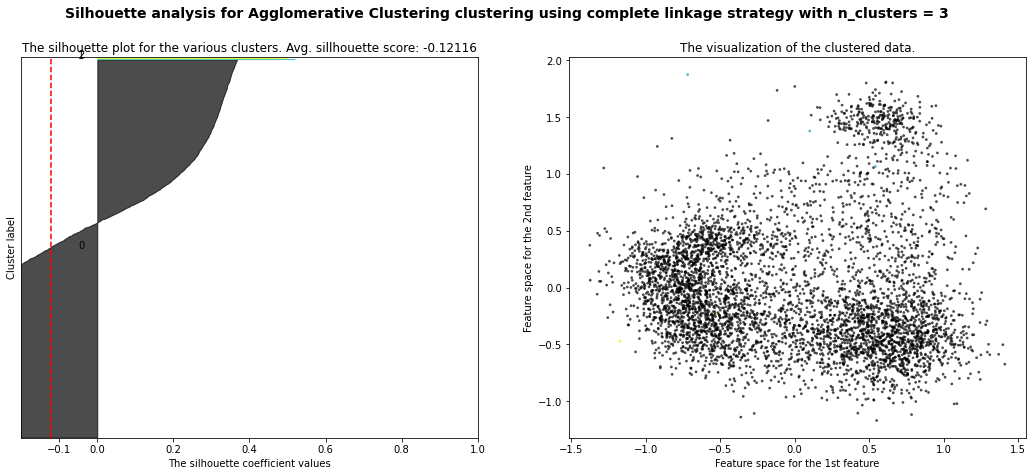

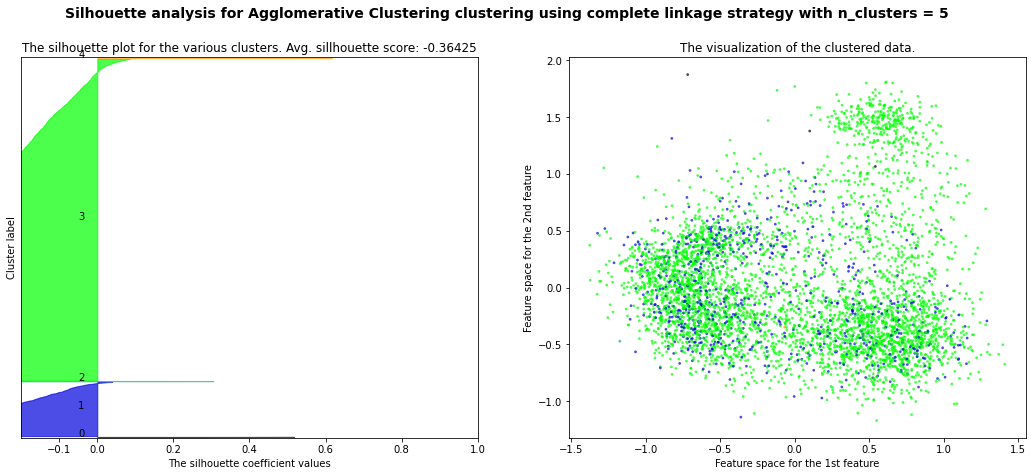

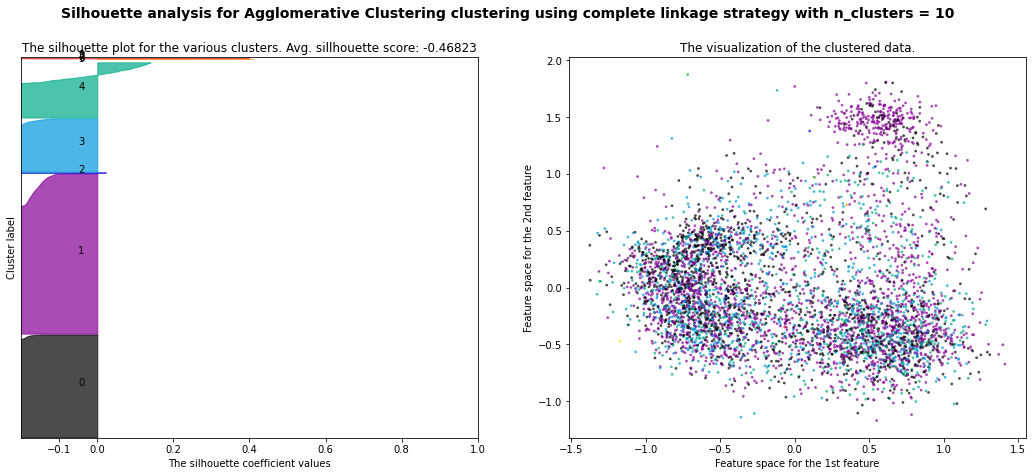

In [42]:
results_after_PCA = []

for method in methods:
    for linkage_strategy in linkage_strategies:
        for n_clusters in range_n_clusters:
            clusterer, cluster_labels = cluster(X_PCA_transformed, method, n_clusters, linkage_strategy)

            silhouette_avg = silhouette_score(X_PCA_transformed[:, :2], cluster_labels)
            if method == "Agglomerative Clustering":
                print("For n_clusters = {0:2} (linkage strategy: {1}) the average silhouette_score is: {2}".format(n_clusters, linkage_strategy, silhouette_avg))
            else:
                print("For n_clusters = {0:2} the average silhouette_score is: {1}".format(n_clusters, silhouette_avg))
            
            # Compute the silhouette scores for each sample
            sample_silhouette_values = silhouette_samples(X_PCA_transformed[:, :2], cluster_labels)

            plot_clusters(X_PCA_transformed, cluster_labels, n_clusters, method, sample_silhouette_values)

            linkage = linkage_strategy
            if method != "Agglomerative Clustering":
                linkage = ""
            results_after_PCA.append({
                "method" : method,
                "n_clusters": n_clusters,
                "linkage_strategy": linkage,
                "silhouette_score": silhouette_avg
            })
        if method != "Agglomerative Clustering":
            break
plt.show()

In [43]:
df_task3 = pd.DataFrame.from_records(results_after_PCA)
df_task3

method  n_clusters linkage_strategy  silhouette_score
0                    K-means           3                           0.532348
1                    K-means           5                           0.275510
2                    K-means          10                           0.020866
3           Gaussian Mixture           3                           0.205851
4           Gaussian Mixture           5                           0.235775
5           Gaussian Mixture          10                           0.036003
6   Agglomerative Clustering           3             ward          0.461153
7   Agglomerative Clustering           5             ward          0.222710
8   Agglomerative Clustering          10             ward         -0.005939
9   Agglomerative Clustering           3           single          0.226398
10  Agglomerative Clustering           5           single         -0.333170
11  Agglomerative Clustering          10           single         -0.620927
12  Agglomerative Clustering           3         complete         -0.121157
13  Agglomerative Clustering           5         complete         -0.364252
14  Agglomerative Clustering          10         complete         -0.468234

Best results are found when using K-means with 5 clusters, while K-means with 3 clusters is very close.

Let's compare results from Task 2 and Task 3:

In [44]:
new_df = pd.merge(df_task2, 
                  df_task3, 
                  how='left', 
                  left_on=['method','n_clusters', 'linkage_strategy'],
                  right_on=['method','n_clusters', 'linkage_strategy'])
new_df = new_df.rename(columns={"silhouette_score_x": "Silhouette Score Task 2", "silhouette_score_y" : "Silhouette Score Task 3"})

In [45]:
new_df

method  n_clusters linkage_strategy  \
0                    K-means           3                    
1                    K-means           5                    
2                    K-means          10                    
3           Gaussian Mixture           3                    
4           Gaussian Mixture           5                    
5           Gaussian Mixture          10                    
6   Agglomerative Clustering           3             ward   
7   Agglomerative Clustering           5             ward   
8   Agglomerative Clustering          10             ward   
9   Agglomerative Clustering           3           single   
10  Agglomerative Clustering           5           single   
11  Agglomerative Clustering          10           single   
12  Agglomerative Clustering           3         complete   
13  Agglomerative Clustering           5         complete   
14  Agglomerative Clustering          10         complete   

    Silhouette Score Task 2  Silhouette Score Task 3  
0                  0.033828                 0.532348  
1                  0.034595                 0.275510  
2                  0.027321                 0.020866  
3                  0.033808                 0.205851  
4                  0.029000                 0.235775  
5                  0.028978                 0.036003  
6                  0.025069                 0.461153  
7                  0.023781                 0.222710  
8                  0.009677                -0.005939  
9                  0.399906                 0.226398  
10                 0.338070                -0.333170  
11                 0.280803                -0.620927  
12                 0.399906                -0.121157  
13                 0.279969                -0.364252  
14                 0.276007                -0.468234

In those cases where the clustering didn't fail (it failed in cases of Agglomerative Clustering with single and complete linkage), we can observe that usually Silhouette Score is higher after applying the PCA, and calculating it over first two components.

First two components of PCA retain >70% of variance. The space becomes mostly dense, as opposed to very sparse data in high-dimensional (original) space. Therefore, intra-cluster distances are smaller which makes the value of the Silhouette Score higher. 

# Task 4.

Visualise the first 5 PCA components. Divide each component direction into 100 intervals (bins) and plot 5 bar-charts showing the distribution of words along each component. Label the bars in your bar-chart by words sampled from each bin. Try to explain what features of words are represented by individual PCA components.

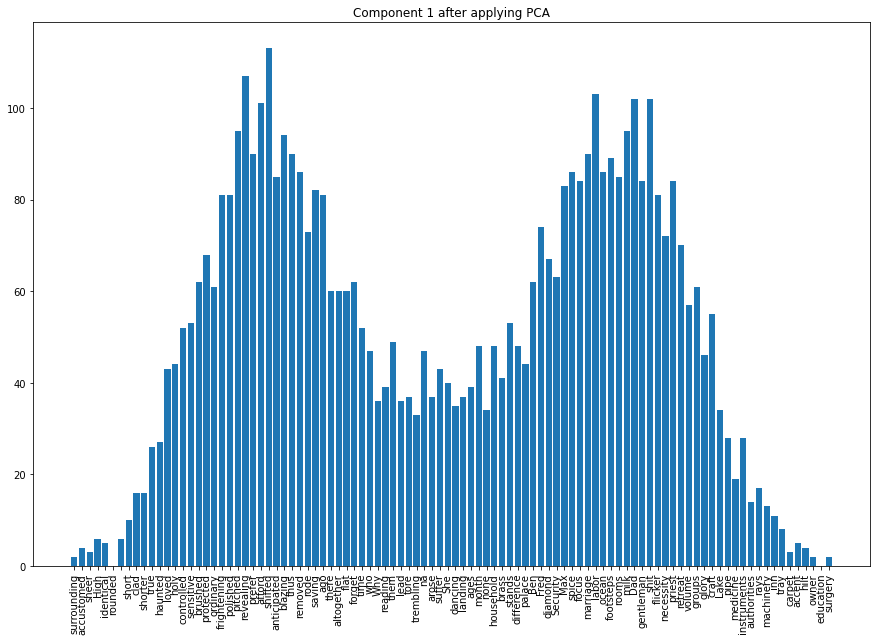

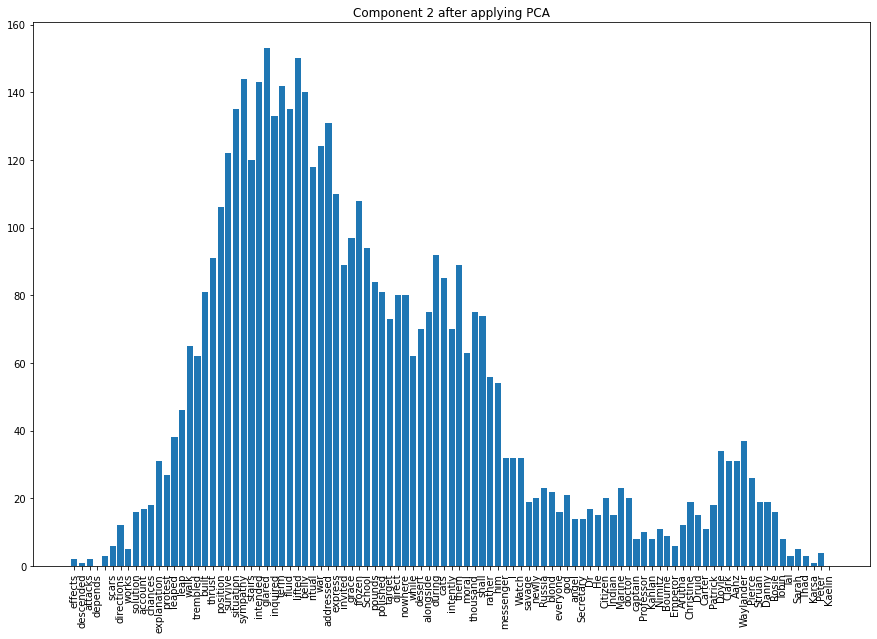

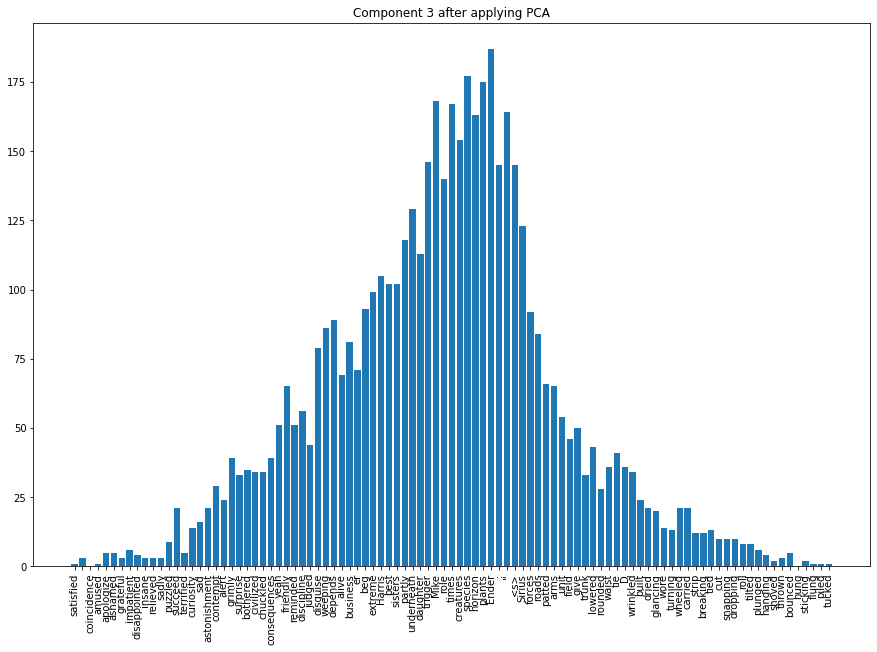

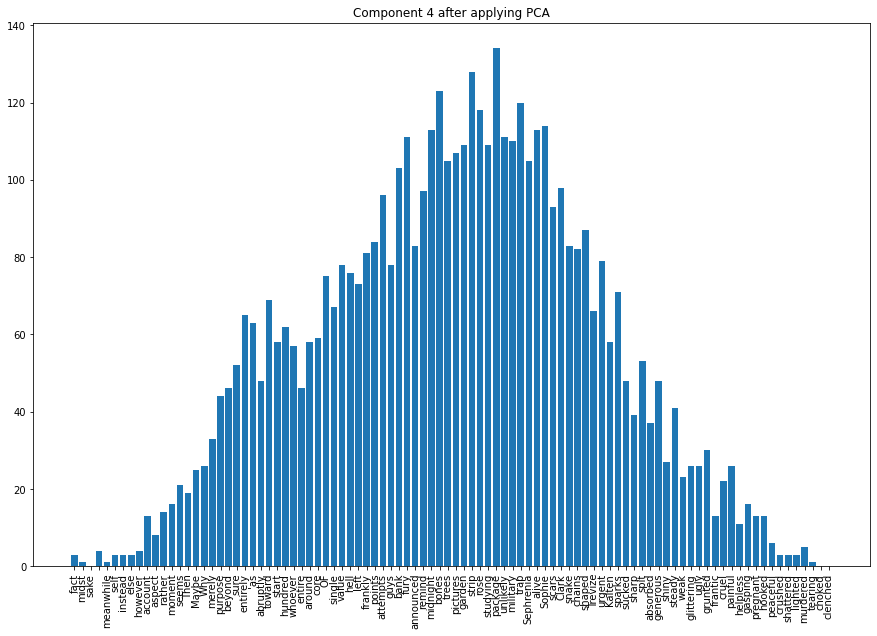

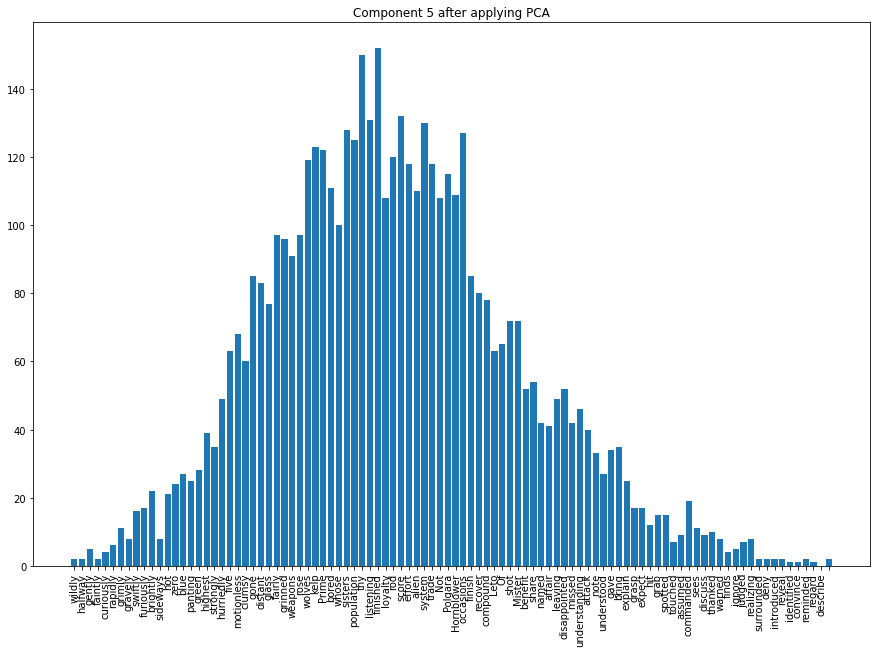

In [28]:
np.random.seed(1234)

for i in range(5):
    component = X_PCA_transformed[:, i]
    
    component_hist, bins_edges = np.histogram(component, bins=100)

    x_ticks = []
    left_edge = -2.0
    for right_edge in bins_edges:
        indices = [i for i in range(len(component)) if component[i] >= left_edge and component[i] <= right_edge]
        if len(indices) == 0:
            x_ticks.append("")
            continue

        chosen_idx = np.random.choice(indices)
        x_ticks.append(words[chosen_idx])
        
        left_edge = right_edge
    
    x_ticks.pop()
    
    plt.figure(figsize=(15, 10))
    plt.bar(x_ticks, component_hist)
    plt.xticks(rotation=90)
    plt.title("Component {} after applying PCA".format(i + 1))
    plt.show()

- Component 1 
    - low values: surrounding, accustomed, sheer, high, identical, rounded, short, clad, shorter, true
    - high values: medicine, instruments, authorities, rays, machinery, inn, tray, carpet, owner, education, surgery
    - This component seems to assign low values to adjectives and assigns higher values to nouns. No particular type of nouns can be seen in the data, 

- Component 2
    - low values: effects, descended, attacks, depends, scars, direction, works, solution, account, chances
    - high values: Doyle, Patrick, Clark, Aahz, Pierce, Danny, Sarah, Karsa, Peter, Kaelin
    - This component clearly assigns high values to proper names.
    
- Component 3
    - low values: satisfied, coincidence, amuzed, apologize, ashamed, grateful, impatient, dissapointed, insane, sadly
    - high values: breaking, tied, cut, snapping, dropping, tilted, plunged, hanging, shoved, thrown, bounced, hung, sticking, tucked
    - This component assigns high values to the terms related to some kind of a bad state or action
    
- Component 4
    - low values: fact, midst, sake, meanwhile, self, instead, else, however, aspect, rather
    - high values: glittering, ugly, grunted, frantic, cruel, painful, helpless, crushed, shattered, murdered, tearing, choked
    - This component assigns high values to participle forms of verbs (both past *-ed* and present *-ing*) 

- Component 5
    - low values: wildly, halfway, gently, faintly, rapidly, grimly, swiftly, absently, happily
    - high values: touched, assumed, sees, discuss, thanked, finds, ignore, deny, reveal, convince, reminded, describe
    - This component assigns low values to adverbs and high values to verbs related to communication

# Task 5

Compute the Independent Component Analysis and obtain 50 independent components. Use `sklearn.decomposition.FastICA` with the parameter `n_components=50` to perform transformation into first 50 PCA components as a pre-processing step. Visualize 5 chosen components in the same way as in the Task 4. Are they non-Gaussian? What features of words they represent? Hint: Look at the long tails of the distributions.

In [29]:
fast_ICA = FastICA(n_components=50,
                  random_state=42)

X_ICA_transformed = fast_ICA.fit_transform(word_vectors)

In [30]:
X_ICA_transformed.shape

(5000, 50)

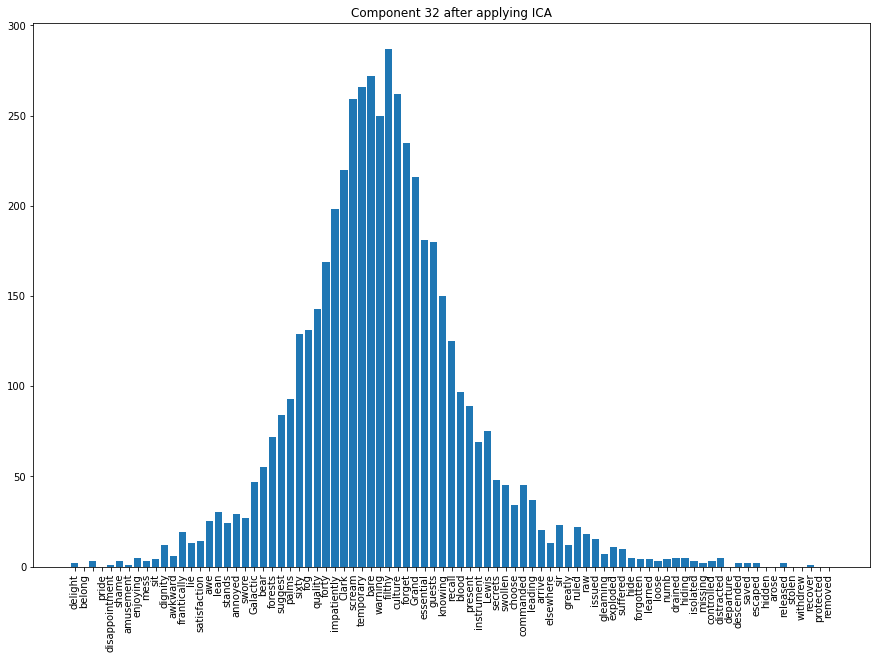

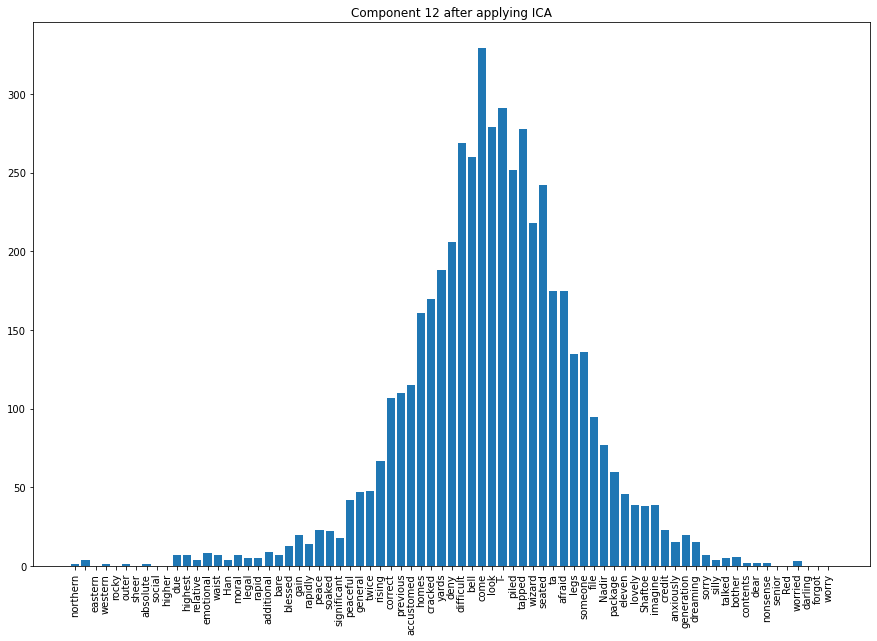

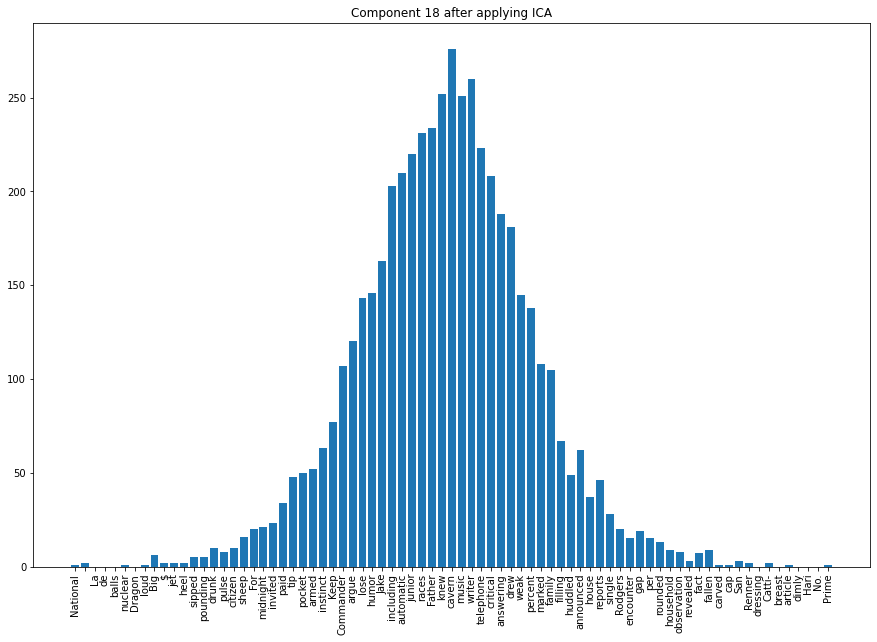

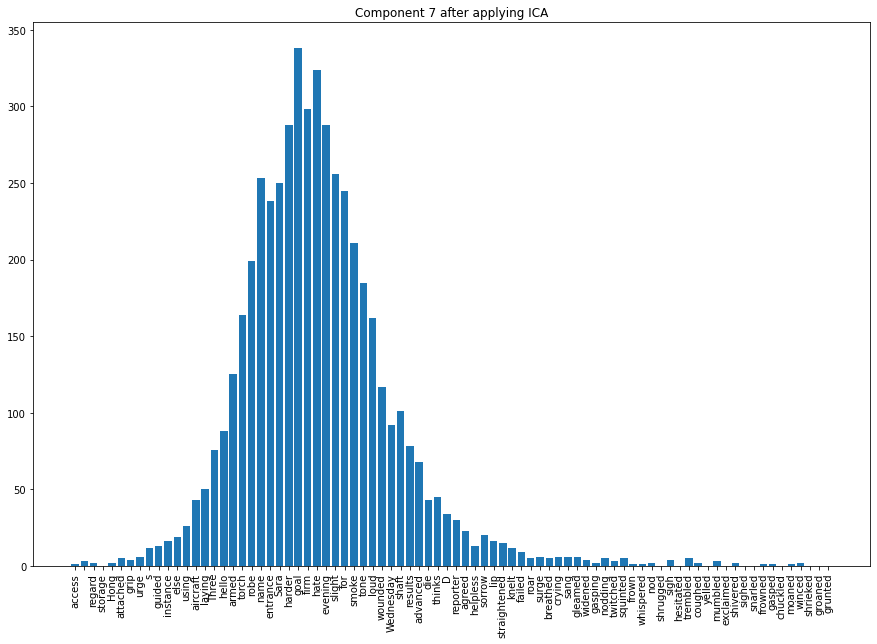

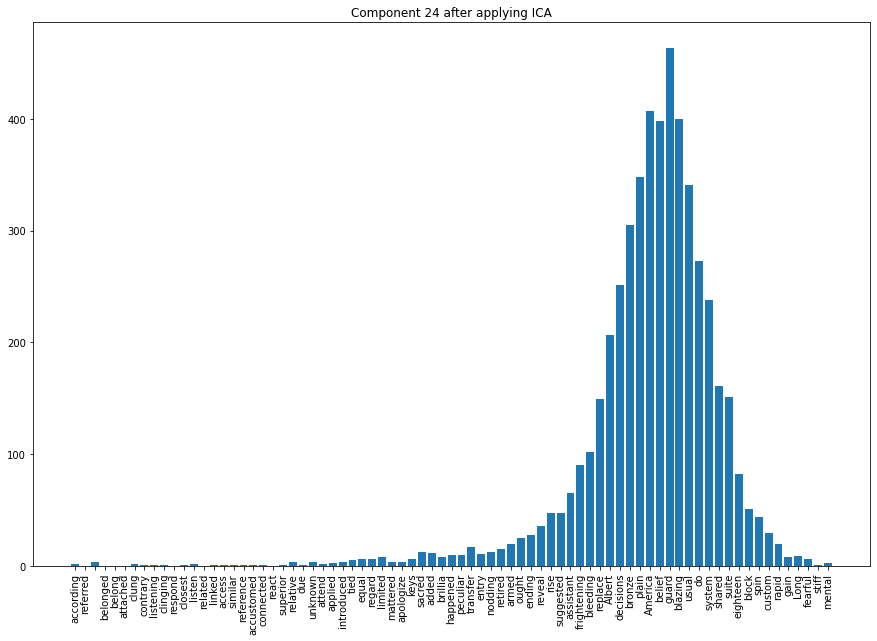

In [31]:
np.random.seed(101)

for i in np.random.choice(range(50), size=5):
    component = X_ICA_transformed[:, i]
    
    component_hist, bins_edges = np.histogram(component, bins=100)

    x_ticks = []
    left_edge = -2.0
    for right_edge in bins_edges:
        indices = [i for i in range(len(component)) if component[i] >= left_edge and component[i] <= right_edge]
        if len(indices) == 0:
            x_ticks.append("")
            continue

        chosen_idx = np.random.choice(indices)
        x_ticks.append(words[chosen_idx])
        
        left_edge = right_edge
    
    x_ticks.pop()
    
    plt.figure(figsize=(15, 10))
    plt.bar(x_ticks, component_hist)
    plt.xticks(rotation=90)
    plt.title("Component {} after applying ICA".format(i + 1))
    plt.show()

The distributions are Gaussian. 




Component 32:
- low value words: delight belong pride shame amusement enjoying 
- high value words: removed protected recover withdrew stolen released saved
- this component assigns higher values to verbs related to 

Component 12:
- low value words: northern eastern western rocky outer
- high value words: worried worry darling forgot senior 
- this component assigns low values to adjectives regarding location, and assigns high values to the words related to worrying feelings and also family members

Component 18:
- low value words: National La de Dragon nuclear Big loud
- high value words: Prime No. dimly article Catti dressing

Component 7:
- low value words: access regard storage Hong attached grip urge
- high value words: grunted groaned moaned gasped sighed mumbled
- this component assigns high values to verbs in past tense, and especially the verbs which describe actions of producing sounds

Component 24:
- this component assigns higher values to religious terms, but also there are words not related to religion at all

In [32]:
# Component 24
c = X_ICA_transformed[:, 23]
indices = np.where(c > 1.90e-02)
print(words[indices])

['short' 'fear' 'chance' 'job' 'force' 'figure' 'foot' 'battle' 'ways'
 'twice' 'burst' 'Sir' 'interested' 'double' 'coat' 'mistake' 'received'
 'rough' 'possibility' 'Man' 'process' '---' 'mental' 'century' 'agent'
 'Granny' 'practice' 'Jesus' 'planned' 'kicked' '/' 'rule' 'figured'
 'trick' 'gasped' 'capable' 'tore' 'crack' 'Nanny' 'ease' 'tough'
 'freedom' 'prevent' 'program' 'o' 'planning' 'satisfaction' 'stiff'
 'farm' 'cap' 'grasp' 'degree' 'gain' 'skill' 'appreciate' 'tension'
 'activity' 'engineer' 'raced' 'knock' 'gon' 'Union' 'habit' 'eased'
 'wisdom' 'engines' 'succeeded' 'region' 'stained' 'ragged' 'intention'
 'Let' 'Citizen' 'suffer' 'racing' 'gained' 'intent' 'soil' 'brightly'
 'beg' 'instinct' 'Holy' 'pardon' 'chaos' 'rapid' 'tense' 'temper'
 'sniffed' 'weakness' 'sweep' 'Time' 'ages' 'urged' 'tearing' 'forcing'
 'basis' 'fond' 'interests' 'Castle' 'starts' 'closet' 'em' 'hesitation'
 'goal' 'custom' 'ringing' 'dig' 'stations' 'twitched' 'recorded'
 'accomplished' 'mach